# Introduction

這個專案的目的是要來預測乳牛的乳量。

資料集是由 AIDEA 下載。

整個議題的首頁在[這裏](https://aidea-web.tw/topic/fcc338da-e7ec-4d9e-a860-5dcdd85ba52b). 

評價的準則是 Root-Mean-Square Error, RMSE：

$$\sqrt{\frac{1}{n}\sum^n_{i=1}(y_i - \hat{y_i})^2}$$


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from ydata_profiling import ProfileReport
import sweetviz as sv
# to support Chinese font
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

# 載入資料

資料共有 
- report.csv
- birth.csv (分娩資料)
- breed.csv (配種資料)
- spec.csv (健康狀況)

主要的資料記錄在 report.csv。
由分娩資料中可以得到牛隻的體重。  
由 spec 可以得到牛隻的建康狀況。  
在本專案中，比較沒有用到 breed.csv (或者說沒有足夠的 domain knowledge，所以不知道要怎麼用這個資料)

In [2]:
df = pd.read_csv('data/report.csv')
df.head()

C:\Users\User\AppData\Local\Temp/ipykernel_19512/3677042329.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/report.csv')


,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
0,1,2013,3,A,52612,507H7173,96040545,2011/1/1 00:00,1,78.0,...,2013/1/1 00:00,2013/3/20 00:00,26,2013/3/21 00:00,2015/5/5 00:00,507H11621,1,NaN,2013/3/5 00:00,501H8784
1,2,2013,4,A,52612,507H7173,96040545,2011/1/1 00:00,1,107.0,...,2013/1/1 00:00,2013/4/18 00:00,27,2013/4/19 00:00,2015/5/5 00:00,507H11621,1,NaN,2013/3/5 00:00,501H8784
2,3,2013,5,A,52612,507H7173,96040545,2011/1/1 00:00,1,140.0,...,2013/1/1 00:00,2013/5/21 00:00,28,2013/5/22 00:00,2015/5/5 00:00,507H11621,2,NaN,2013/3/5 00:00,501H8784
3,4,2013,6,A,52612,507H7173,96040545,2011/1/1 00:00,1,175.0,...,2013/1/1 00:00,2013/6/25 00:00,29,2013/6/26 00:00,2015/5/5 00:00,507H11621,2,NaN,2013/3/5 00:00,501H8784
4,5,2013,7,A,52612,507H7173,96040545,2011/1/1 00:00,1,210.0,...,2013/1/1 00:00,2013/7/30 00:00,30,2013/7/31 00:00,2015/5/5 00:00,507H11621,2,NaN,2013/3/5 00:00,501H8784


## 將欄位改成中文

每個欄位的中文名稱可以見官方網頁的說明

In [3]:
# rename columns
field_name = {
    '1': 'ID',
    '2': '資料年度',
    '3': '資料月份',
    '4': '酪農場代號',
    '5': '乳牛編號',
    '6': '父親牛精液編號',
    '7': '母親乳牛編號',
    '8': '出生日期',
    '9': '胎次',
    '10': '泌乳天數',
    '11': '乳量',
    '12': '最近分娩日期',
    '13': '採樣日期',
    '14': '月齡',
    '15': '檢測日期',
    '16': '最後配種日期',
    '17': '最後配種精液',
    '18': '配種次數',
    '19': '前次分娩日期',
    '20': '第一次配種日期',
    '21': '第一次配種精液'
}
df.rename(columns=field_name, inplace=True)
df.head()

,ID,資料年度,資料月份,酪農場代號,乳牛編號,父親牛精液編號,母親乳牛編號,出生日期,胎次,泌乳天數,...,最近分娩日期,採樣日期,月齡,檢測日期,最後配種日期,最後配種精液,配種次數,前次分娩日期,第一次配種日期,第一次配種精液
0,1,2013,3,A,52612,507H7173,96040545,2011/1/1 00:00,1,78.0,...,2013/1/1 00:00,2013/3/20 00:00,26,2013/3/21 00:00,2015/5/5 00:00,507H11621,1,NaN,2013/3/5 00:00,501H8784
1,2,2013,4,A,52612,507H7173,96040545,2011/1/1 00:00,1,107.0,...,2013/1/1 00:00,2013/4/18 00:00,27,2013/4/19 00:00,2015/5/5 00:00,507H11621,1,NaN,2013/3/5 00:00,501H8784
2,3,2013,5,A,52612,507H7173,96040545,2011/1/1 00:00,1,140.0,...,2013/1/1 00:00,2013/5/21 00:00,28,2013/5/22 00:00,2015/5/5 00:00,507H11621,2,NaN,2013/3/5 00:00,501H8784
3,4,2013,6,A,52612,507H7173,96040545,2011/1/1 00:00,1,175.0,...,2013/1/1 00:00,2013/6/25 00:00,29,2013/6/26 00:00,2015/5/5 00:00,507H11621,2,NaN,2013/3/5 00:00,501H8784
4,5,2013,7,A,52612,507H7173,96040545,2011/1/1 00:00,1,210.0,...,2013/1/1 00:00,2013/7/30 00:00,30,2013/7/31 00:00,2015/5/5 00:00,507H11621,2,NaN,2013/3/5 00:00,501H8784


# 預測目標

在 report.csv 中，只要「乳量」欄位為空的，就是要預測的對象。

因為只有 2019 年的乳量是空值，所以就是要預測 2019 年的乳量

In [4]:
# obtain all the records that 乳量 is null
df[df['乳量'].isnull()]['資料年度'].value_counts()

資料年度
2019    4263
Name: count, dtype: int64

## 資料特性

針對要預測的對象，我們看一下這些對象的特性。

我們想知道的問題是：  
這些要預測的對象，過去曾經存在歷史資料嗎？例如要預測牛隻 $s$ 在 2019 年 3 月的乳量，那麼資料表中有 $s$ 在 2019 年前的資訊嗎？

底下的分析可以發現：
1. 存在有大量的牛隻，是只有 2019 才有資料的
2. 也有部分的牛隻，是在 2018 年就有歷史資料的。

針對 2，是可以用牛隻歷史資料來預測結果。

In [5]:
# retrieval the records that 乳量 is null and 資料年度 is 2019
df2019 = df[(df['乳量'].isnull()) & (df['資料年度'] == 2019)]
cow_id_to_predict = df2019['乳牛編號'].unique()
# retrieval the records that 資料年度 is not 2019
dfhistory = df[df['資料年度'] != 2019]
cow_id_history = dfhistory['乳牛編號'].unique()
print('在過去從沒有出現過的乳牛編號:\n', np.setdiff1d(cow_id_to_predict, cow_id_history))

在過去從沒有出現過的乳牛編號:
 [ 2126913  2126917  2126919  2127035  2127037  2127042  2127044  2127048
  2127049  2127050  2127052  2127054  2127055  2127056  2127057  2127058
  2127061  2127062  2127063  2127064  2127065  2127068  2127069  2127070
  2127071  2127072  2127079  2127081  2127085  2127086  2127087  2127090
  2127092  2127098  2127099  2127100  2127103  2127105  2127109  2127144
  4051533  4051576  4125742  4126642  4126643  4126656  4127116  4127124
  4127125  4127140  4127141  5051813  5051845  5051846  5051847  5051850
  5051852  5051853  5051854  5051855  5051856  5051857  5051858  5051859
  5051864  5051865  5051867  5051868  5051869  5051873  5051876  5051878
  5051879  5051881  5051882  5051883  5051886  5125726  5125753  5125768
  5125778  5128433  5128434  5128436  5128440  5128441  5128443  5128445
  5128446  5128449  5128450  5128451  5128453  5128454  5128455  5128457
  5128458  5128459  5128460  5128461  5128464  5128466  5128467  5128469
  5128470  5129145  5129147  51291

In [6]:
# 從沒出現過的乳牛編號，會在 2019 出現，然後有乳量嗎？
ids = np.setdiff1d(cow_id_to_predict, cow_id_history)
# retrieve the records that 乳牛編號 is in ids and 資料年度 is 2019 and 乳量 is not null
df2019 = df[df['資料年度'] == 2019]
df2019[(df2019['乳牛編號'].isin(ids)) & (df2019['乳量'].notnull())]

,ID,資料年度,資料月份,酪農場代號,乳牛編號,父親牛精液編號,母親乳牛編號,出生日期,胎次,泌乳天數,...,最近分娩日期,採樣日期,月齡,檢測日期,最後配種日期,最後配種精液,配種次數,前次分娩日期,第一次配種日期,第一次配種精液


由上面的分析可以看到，需要預測過去沒有出現的乳牛的乳量。

由底下一格可以看到，這些乳牛有月齡，配種次數之類的資料，要由這些資料推論出乳量。

因此不能依賴乳牛編號來推論一頭牛的乳量。

In [7]:
df.loc[df['乳牛編號'] == 2126913, ['乳量', '泌乳天數', '月齡', '配種次數', '胎次', '乳牛編號', '資料年度', '資料月份']]

,乳量,泌乳天數,月齡,配種次數,胎次,乳牛編號,資料年度,資料月份
16648,NaN,54.0,24,0,1,2126913,2019,5
16649,NaN,24.0,23,0,1,2126913,2019,4
16650,NaN,81.0,25,0,1,2126913,2019,6
16651,NaN,111.0,26,1,1,2126913,2019,7


是否存在有乳牛，其有過去的歷史資訊呢？

In [8]:
print('在過去曾經出現過的乳牛編號:\n', np.union1d(cow_id_to_predict, cow_id_history))

在過去曾經出現過的乳牛編號:
 [   52612    52613    52614 ... 99183209 99183210 99183211]


前述的牛隻，因為過去就存在有資訊，應該可以用過去的歷史來預測它們的產量。

# 處理 Spec

Spec 中應該記錄的是有問題牛隻的狀況。

所以可以把這些健康狀況放入我們要訓練的資料集中。

In [9]:
'''
1	乳牛編號
2	狀況類別
3	狀況代號
4	狀況日期
5	備註
6	登錄日期
7	酪農場代號
'''
colname = {
    '1': '乳牛編號',
    '2': '狀況類別',
    '3': '狀況代號',
    '4': '狀況日期',
    '5': '備註',
    '6': '登錄日期',
    '7': '酪農場代號'
}
dfspec = pd.read_csv('data/spec.csv')
dfspec.rename(columns=colname, inplace=True)
dfspec.head()

,乳牛編號,狀況類別,狀況代號,狀況日期,備註,登錄日期,酪農場代號
0,5022341,N,NaN,1999/8/24 00:00,NaN,NaN,A
1,5022362,N,NaN,1999/8/24 00:00,NaN,NaN,A
2,5022365,N,NaN,1999/8/24 00:00,NaN,NaN,A
3,5022372,N,NaN,1999/8/24 00:00,NaN,NaN,A
4,5022373,N,NaN,1999/8/24 00:00,NaN,NaN,A


處理資料，把出狀況的月分，還有年取出來。

In [10]:
# convert 狀況日期 to datetime
dfspec['狀況日期'] = pd.to_datetime(dfspec['狀況日期'])
# retrieve year and month from 狀況日期
dfspec['year'] = dfspec['狀況日期'].dt.year
dfspec['month'] = dfspec['狀況日期'].dt.month
dfspec.head()

,乳牛編號,狀況類別,狀況代號,狀況日期,備註,登錄日期,酪農場代號,year,month
0,5022341,N,NaN,1999-08-24,NaN,NaN,A,1999,8
1,5022362,N,NaN,1999-08-24,NaN,NaN,A,1999,8
2,5022365,N,NaN,1999-08-24,NaN,NaN,A,1999,8
3,5022372,N,NaN,1999-08-24,NaN,NaN,A,1999,8
4,5022373,N,NaN,1999-08-24,NaN,NaN,A,1999,8


狀況類別中有大寫，也有小寫，一律改成大寫

In [11]:
dfspec['狀況類別'].value_counts()

狀況類別
C    2962
D     782
N     612
n       2
2       2
1       1
c       1
Name: count, dtype: int64

In [12]:
dfspec['狀況類別'] = dfspec['狀況類別'].str.upper()
dfspec['狀況類別'].value_counts()

狀況類別
C    2963
D     782
N     614
2       2
1       1
Name: count, dtype: int64

## 將建康狀況回寫到 train 資料集中

使用的程式碼參考[這裏](https://github.com/omega87910/AIDEA_lactation_yield_predict/blob/master/cow_mlik.ipynb)

原則，若當月的資料有記錄在 spec 中， health 欄位就是狀況類別。

狀況是：
- H 代表健康
- N 代表不健康

其實 Spec 中不健康的代號還有很多，但不確定這些代號的意思。所以一律用 N 這個代號來替代。

In [13]:
''' Scan dfspec, for each 乳牛編號 a, search in the df. 
If a is in df.乳牛編號 and df.資料年度 and df.資料月份 is the same as dfspec.狀況日期, 
then add a new column to df, named health, and assign the value of dfspec.狀況代號 to it.
'''
df['health'] = 'H' # H means healthy
for i, row in dfspec.iterrows():
    cow_id = row['乳牛編號']
    # retrieve the year and month from row['狀況日期']
    yyyy = row.year
    mm = row.month
    #health = row['狀況代號']
    df.loc[(df['乳牛編號'] == cow_id) & (df['資料年度'] == yyyy) & (df['資料月份'] == mm), 'health'] = 'N'

df.head()

,ID,資料年度,資料月份,酪農場代號,乳牛編號,父親牛精液編號,母親乳牛編號,出生日期,胎次,泌乳天數,...,採樣日期,月齡,檢測日期,最後配種日期,最後配種精液,配種次數,前次分娩日期,第一次配種日期,第一次配種精液,health
0,1,2013,3,A,52612,507H7173,96040545,2011/1/1 00:00,1,78.0,...,2013/3/20 00:00,26,2013/3/21 00:00,2015/5/5 00:00,507H11621,1,NaN,2013/3/5 00:00,501H8784,H
1,2,2013,4,A,52612,507H7173,96040545,2011/1/1 00:00,1,107.0,...,2013/4/18 00:00,27,2013/4/19 00:00,2015/5/5 00:00,507H11621,1,NaN,2013/3/5 00:00,501H8784,H
2,3,2013,5,A,52612,507H7173,96040545,2011/1/1 00:00,1,140.0,...,2013/5/21 00:00,28,2013/5/22 00:00,2015/5/5 00:00,507H11621,2,NaN,2013/3/5 00:00,501H8784,H
3,4,2013,6,A,52612,507H7173,96040545,2011/1/1 00:00,1,175.0,...,2013/6/25 00:00,29,2013/6/26 00:00,2015/5/5 00:00,507H11621,2,NaN,2013/3/5 00:00,501H8784,H
4,5,2013,7,A,52612,507H7173,96040545,2011/1/1 00:00,1,210.0,...,2013/7/30 00:00,30,2013/7/31 00:00,2015/5/5 00:00,507H11621,2,NaN,2013/3/5 00:00,501H8784,H


In [14]:
df.health.value_counts()

health
H    37037
N      480
Name: count, dtype: int64

# 處理 birth

Birth 主要是要取得牛隻的體重。

乾乳日期應該也是一個個重要的資訊，但因為沒有足夠的 domain knowledge，所以不確定要如何利用它。  
同理，胎次，分娩難易度可能也會影響乳量，但不確定要如何做，所以本次忽略。

In [15]:
'''
1	乳牛編號
2	分娩日期
3	乾乳日期
4	犢牛編號1
5	犢牛編號2
6	母牛體重
7	登錄日期
8	計算胎次
9	胎次
10	分娩難易度
11	犢牛體型
12	犢牛性別
13	酪農場代號
'''
cols = {
    '1': '乳牛編號',
    '2': '分娩日期',
    '3': '乾乳日期',
    '4': '犢牛編號1',
    '5': '犢牛編號2',
    '6': '母牛體重',
    '7': '登錄日期',
    '8': '計算胎次',
    '9': '胎次',
    '10': '分娩難易度',
    '11': '犢牛體型',
    '12': '犢牛性別',
    '13': '酪農場代號'    
}
dfbirth = pd.read_csv('data/birth.csv')
dfbirth.rename(columns=cols, inplace=True)
dfbirth.head()


,乳牛編號,分娩日期,乾乳日期,犢牛編號1,犢牛編號2,母牛體重,登錄日期,計算胎次,胎次,分娩難易度,犢牛體型,犢牛性別,酪農場代號
0,87121677,2013/1/4 00:00,NaN,NaN,NaN,NaN,2013/1/25 00:00,True,2,1.0,NaN,NaN,B
1,96126940,2013/1/2 00:00,NaN,NaN,NaN,522.0,2013/1/25 00:00,True,2,2.0,NaN,NaN,B
2,95181708,2013/1/14 00:00,2014/1/3 00:00,2188113,NaN,670.0,2013/1/25 00:00,True,5,1.0,NaN,NaN,C
3,97127665,2013/1/9 00:00,2014/3/12 00:00,NaN,NaN,NaN,2013/1/25 00:00,True,3,2.0,NaN,NaN,B
4,97182634,2013/1/9 00:00,2014/3/25 00:00,NaN,NaN,630.0,2013/1/25 00:00,True,4,1.0,NaN,NaN,C


## 分析體重資料的特性
不同的酪農場，牛隻的平均體重略有不同

In [16]:
# 計算不同酪農場的乳牛數量，平均體重
dfbirth.groupby('酪農場代號').agg({'乳牛編號': 'count', '母牛體重': 'mean'})


,乳牛編號,母牛體重
酪農場代號,,
A,813,NaN
B,2276,547.000000
C,672,578.350746


一頭牛在不同時期也有不同的體重

In [17]:
dfbirth[dfbirth['乳牛編號'] == 97182634]

,乳牛編號,分娩日期,乾乳日期,犢牛編號1,犢牛編號2,母牛體重,登錄日期,計算胎次,胎次,分娩難易度,犢牛體型,犢牛性別,酪農場代號
4,97182634,2013/1/9 00:00,2014/3/25 00:00,NaN,NaN,630.0,2013/1/25 00:00,True,4,1.0,NaN,NaN,C
555,97182634,2014/4/16 00:00,2015/2/1 00:00,3183640,NaN,650.0,2014/4/25 00:00,True,5,1.0,NaN,NaN,C
1064,97182634,2015/4/1 00:00,2016/2/1 00:00,NaN,NaN,660.0,2015/4/27 00:00,True,6,1.0,NaN,NaN,C
1556,97182634,2015/4/5 00:00,2017/2/16 00:00,NaN,NaN,685.0,2016/4/26 00:00,True,6,1.0,NaN,NaN,C
2149,97182634,2017/4/12 00:00,2018/5/24 00:00,6187430,NaN,700.0,2017/4/26 00:00,True,7,1.0,NaN,母,C
3084,97182634,2018/8/11 00:00,2019/5/31 00:00,NaN,NaN,715.0,2018/8/27 00:00,True,8,1.0,NaN,NaN,C
3758,97182634,2019/7/24 00:00,NaN,NaN,NaN,730.0,2019/7/26 00:00,True,9,1.0,NaN,NaN,C


## 填入空值
用底下的規則填「母牛體重」中的空值  
假設牛隻 $s$ 在某個日期上有空值，那可以用底下的策略填空值：
1. 若 $s$ 在其他的日期上有體重，就用 $s$ 的平均體重填空值
2. 若上述條件不符合，就用同一酪農場牛的體重平均值來填 $s$ 的體重
3. 若這個酪農場的牛的體重都為空值，那就用全部牛的平均體重來填空值

In [18]:
# 計算每頭牛的平均體重
cow_mean_weights = dfbirth.groupby('乳牛編號')['母牛體重'].mean()

# 計算每個酪農場的牛的平均體重
farm_mean_weights = dfbirth.groupby('酪農場代號')['母牛體重'].mean()

# 計算所有牛的平均體重
overall_mean_weight = dfbirth['母牛體重'].mean()
# 依規則填補空值
def fill_missing_weights(row):
    if pd.isna(row['母牛體重']):
        # 如果這頭牛在其他日期有體重記錄，則用該牛的平均體重填補
        if pd.notna(cow_mean_weights[row['乳牛編號']]):
            return cow_mean_weights[row['乳牛編號']]
        # 如果該酪農場的其他牛有體重記錄，則用該酪農場的平均體重填補
        elif pd.notna(farm_mean_weights[row['酪農場代號']]):
            return farm_mean_weights[row['酪農場代號']]
        # 否則用所有牛的平均體重填補
        else:
            return overall_mean_weight
    else:
        return row['母牛體重']

dfbirth['母牛體重'] = dfbirth.apply(fill_missing_weights, axis=1)


In [19]:
# check if there is any missing value in 母牛體重
dfbirth['母牛體重'].isnull().sum()

0

## 將 Birth 中的體重全都回填到主資料表中

把 dfbirth 中的體重填回到 df 中。

In [20]:
dfbirth['登錄日期'] = pd.to_datetime(dfbirth['登錄日期'])
dfbirth['year'] = dfbirth['登錄日期'].dt.year
dfbirth['month'] = dfbirth['登錄日期'].dt.month

底下是第一階段填空值。  
若在主資料表中，牛隻 $s$ 在某年，某月時，剛好在 birth 資料表中，也有它的體重，那就將之填上。

In [21]:
for i, row in dfbirth.iterrows():
    cow_id = row['乳牛編號']
    # retrieve the year and month from row['狀況日期']
    yyyy = row.year
    mm = row.month
    #health = row['狀況代號']
    df.loc[(df['乳牛編號'] == cow_id) & (df['資料年度'] == yyyy) & (df['資料月份'] == mm), 'weight'] = row['母牛體重']

# check if there is any missing value in weight
df['weight'].isnull().sum()

34282

第一階段填完後，還有 34282 筆資料的 weight 是空的。  
所以啟動第二階段填空。  

- 用酪農場的平均體重，來填它的體重。或
- 用所有牛隻的平均體重，來填它的體重。

In [22]:
# 計算每個酪農場的牛的平均體重
farm_mean_weights = df.groupby('酪農場代號')['weight'].mean()

# 計算所有牛的平均體重
overall_mean_weight = df['weight'].mean()
# 依規則填補空值
def fill_missing_weights(row):
    if pd.isna(row['weight']):
        # 如果該酪農場的其他牛有體重記錄，則用該酪農場的平均體重填補
        if pd.notna(farm_mean_weights[row['酪農場代號']]):
            return farm_mean_weights[row['酪農場代號']]
        # 否則用所有牛的平均體重填補
        else:
            return overall_mean_weight
    else:
        return row['weight']
df['weight'] = df.apply(fill_missing_weights, axis=1)
df['weight'].isnull().sum()

0

# 針對 df 處理

觀察乳量在不同酪農場的變化

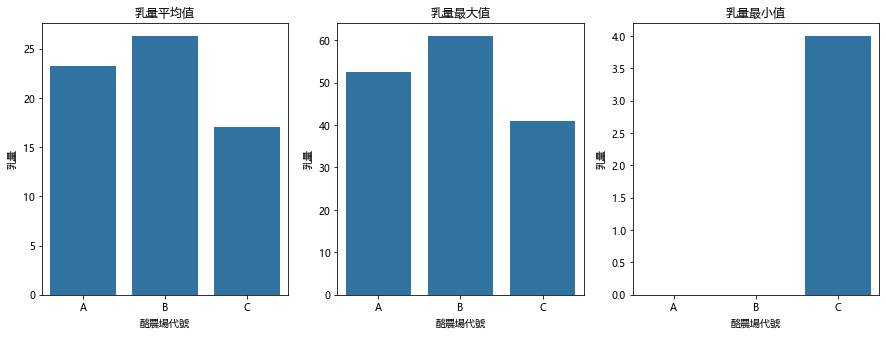

In [23]:
# 針對酪農場代號分組，把每個酪農場代號的乳量平均值，最大值，最小值用 barchart 顯示
# 乳量平均值一張圖 (依酪農場代號分組)，乳量最大值一張圖 (依酪農場代號分組)，乳量最小值一張圖 (依酪農場代號分組)
# 先移除 2019 年的資料
df2 = df.loc[df['資料年度'] != 2019]
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
tmp = df2.groupby('酪農場代號')['乳量'].mean()
sns.barplot(x=tmp.index.values, y=tmp.values)
plt.title('乳量平均值')
plt.ylabel('乳量')
plt.xlabel('酪農場代號')
plt.subplot(1, 3, 2)
tmp = df2.groupby('酪農場代號')['乳量'].max()
sns.barplot(x=tmp.index.values, y=tmp.values)
plt.title('乳量最大值')
plt.ylabel('乳量')
plt.xlabel('酪農場代號')
plt.subplot(1, 3, 3)
tmp = df2.groupby('酪農場代號')['乳量'].min()
sns.barplot(x=tmp.index.values, y=tmp.values)
plt.title('乳量最小值')
plt.ylabel('乳量')
plt.xlabel('酪農場代號')
plt.show()



## 使用 Sweetviz 來做探索式資料分析

Sweetviz 的說明請見[這裏](https://medium.com/jackys-blog/sweetviz-%E4%B8%80%E5%80%8B%E5%9C%A8%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90%E5%89%8D%E5%BF%85%E9%A0%88%E5%85%88%E4%BD%BF%E7%94%A8%E7%9A%84%E5%A5%97%E4%BB%B6-2bdefa8e5e68)

In [24]:
# 把 overwirite.ini 設定檔放在專案目錄下，然後用 sweetviz 產生報告
# overwise.ini 的中主要是要求 sweetviz 要使用中文字型，這樣報告中的中文才會正確顯示
sv.config_parser.read("overwrite.ini")

['overwrite.ini']

In [25]:
# 母親乳牛編號中可能有些資料怪怪的，要加上底下這行，不然 sweetviz 會出問題
df['母親乳牛編號'] = pd.to_numeric(df['母親乳牛編號'], errors='coerce')
my_report = sv.analyze(df)
my_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [26]:
# 列出那些欄位有缺失值
df.isnull().any()

ID         False
資料年度       False
資料月份       False
酪農場代號      False
乳牛編號       False
父親牛精液編號     True
母親乳牛編號      True
出生日期       False
胎次         False
泌乳天數        True
乳量          True
最近分娩日期      True
採樣日期       False
月齡         False
檢測日期       False
最後配種日期      True
最後配種精液      True
配種次數       False
前次分娩日期      True
第一次配種日期     True
第一次配種精液     True
health     False
weight     False
dtype: bool

In [27]:
df.to_csv('data/report_clean.csv', index=False, encoding='utf-8')

In [28]:
df.isna().sum()

ID             0
資料年度           0
資料月份           0
酪農場代號          0
乳牛編號           0
父親牛精液編號      876
母親乳牛編號      6251
出生日期           0
胎次             0
泌乳天數           1
乳量          4263
最近分娩日期         1
採樣日期           0
月齡             0
檢測日期           0
最後配種日期      1536
最後配種精液      1536
配種次數           0
前次分娩日期     17420
第一次配種日期     1431
第一次配種精液     1431
health         0
weight         0
dtype: int64

泌乳天數只有一筆是空的。看來影響不大，就把這筆移除掉

In [29]:
# remove the records that 泌乳天數 is null
df = df[df['泌乳天數'].notnull()]
df.isna().sum()

ID             0
資料年度           0
資料月份           0
酪農場代號          0
乳牛編號           0
父親牛精液編號      876
母親乳牛編號      6250
出生日期           0
胎次             0
泌乳天數           0
乳量          4263
最近分娩日期         0
採樣日期           0
月齡             0
檢測日期           0
最後配種日期      1535
最後配種精液      1535
配種次數           0
前次分娩日期     17419
第一次配種日期     1430
第一次配種精液     1430
health         0
weight         0
dtype: int64

## 移除空值過多的欄位

其他的欄位空值太多了，也不知道怎麼回填，就乾脆都刪掉了。

In [30]:
# remove columns ['父親牛精液編號', '母親乳牛編號', '最後配種日期', '最後配種精液', '前次分娩日期', '第一次配種日期', '第一次配種精液']
df.drop(columns=['父親牛精液編號', '母親乳牛編號', '最後配種日期', '最後配種精液', '前次分娩日期', '第一次配種日期', '第一次配種精液'], inplace=True)
df.isna().sum()

ID           0
資料年度         0
資料月份         0
酪農場代號        0
乳牛編號         0
出生日期         0
胎次           0
泌乳天數         0
乳量        4263
最近分娩日期       0
採樣日期         0
月齡           0
檢測日期         0
配種次數         0
health       0
weight       0
dtype: int64

只剩下乳量為空的 4263 筆，剛好是我們要預測的對象。

In [31]:
def getFarmID(cow_id, df):
    """Given a cow_id, return the farm id of the cow.

    Args:
        cow_id (int): the id of the cow

    Returns:
        str: the farm id of the cow
    """
    df = df.loc[df['乳牛編號'] == cow_id, ['酪農場代號']]
    return df['酪農場代號'].iloc[0]


## 觀察乳量還有胎次的關係

底下的圖把乳量，胎次，還有泌乳天數的關係畫出來。

線條上的數字代表泌乳天數。

基本上來說，泌乳天數越大，乳量應該會越少。

胎次就比較看不出來有什麼影響。有些資料顯示第二胎的乳量會比較高，但也不定是這樣。

第一胎的乳量會比較少嗎？似乎也不一定，可以能要做一個統計檢定才能確定了！

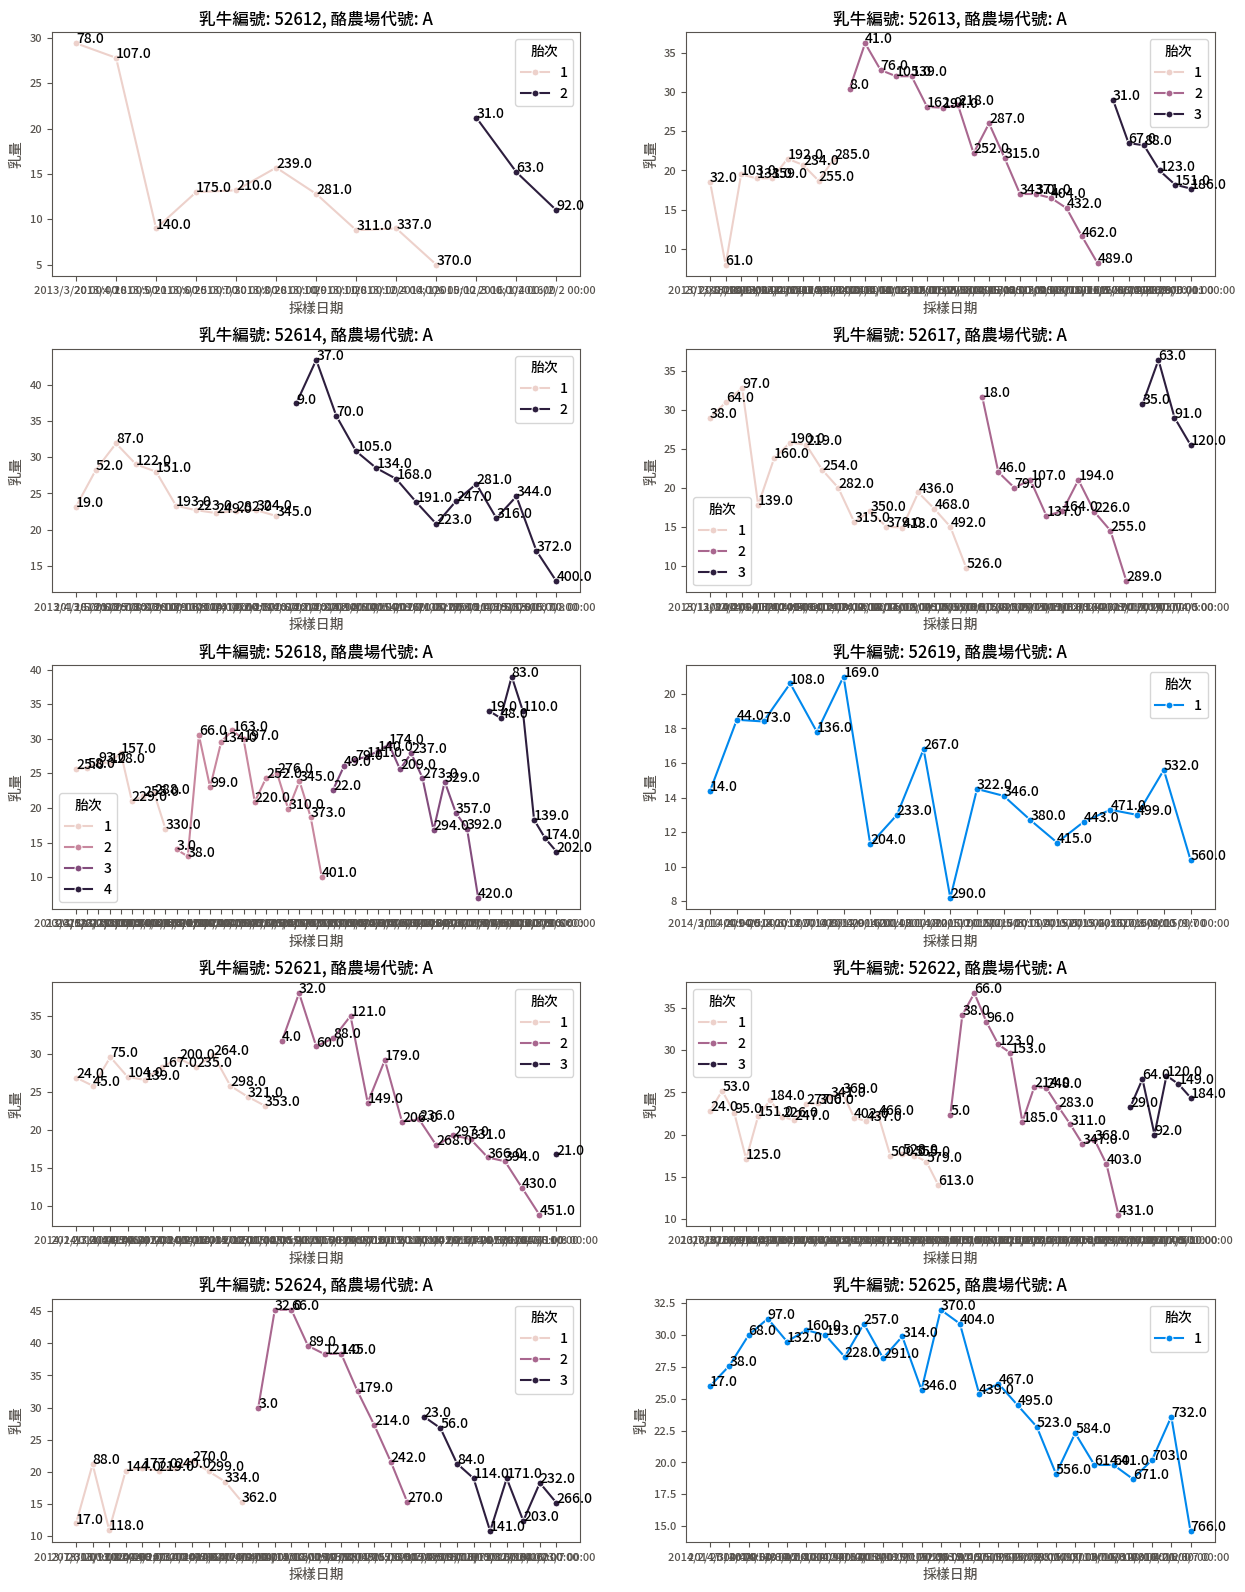

In [32]:
# draw line plots for previous 10 cows on 乳量, use color to distinguish different 胎次. Use subgraphs to show each cow.
# 顯示前10頭乳牛的乳量變化，使用不同顏色區分不同胎次，使用子圖顯示每頭乳牛
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
plt.subplots_adjust(hspace=0.3)  # adjust the space between plots
for i, cow_id in enumerate(df['乳牛編號'].unique()[:10]):
    ax = axes[i // 2, i % 2]
    df_cow = df[df['乳牛編號'] == cow_id]
    df_cow = df_cow.sort_values(['資料年度', '資料月份'])
    # draw markers on the line plot
    sns.lineplot(x=df_cow['採樣日期'].values, y=df_cow['乳量'].values, hue=df_cow['胎次'].values, ax=ax, 
                 marker='o', markersize=5)
    # draw the number on each marker
    for j, txt in enumerate(df_cow['泌乳天數'].values):
        ax.annotate(txt, (df_cow['採樣日期'].values[j], df_cow['乳量'].values[j]))
    #sns.lineplot(data=df_cow, x='採樣日期', y='乳量', hue='胎次', ax=ax)
    ax.set_title(f'乳牛編號: {cow_id}, 酪農場代號: {getFarmID(cow_id, df)}')
    ax.set_xlabel('採樣日期')
    ax.set_ylabel('乳量')
    ax.legend(title='胎次')

## 產生 lagged features

產生滯後特徵 (lagged feature)。

由上一張圖可以看出，乳量其實會有遞減的狀況，所以要預測某年，某月某頭牛隻的乳量時，若能知道它前幾個月的乳量，是會有幫助的。

而滯後特徵，就是把一頭牛前「三個月」的乳量抓出來，併到資料表中。

In [33]:
# convert 採樣日期 to datetime
df['採樣日期'] = pd.to_datetime(df['採樣日期'])
df.sort_values(['乳牛編號', '胎次', '採樣日期'], inplace=True)
def create_lagged_features(df, lag_features, group_cols=['乳牛編號', '胎次']):
  """
  Creates lagged features for a time series dataset.

  Args:
    df: pandas DataFrame containing the time series data.
    lag_features: List of feature names to create lagged versions of.
    group_cols: List of columns to group by when creating lagged features.

  Returns:
    pandas DataFrame with lagged features added.
  """
  for feature in lag_features:
    for lag in range(1, 4):  # Example: Create lags up to 3 periods
      lagged_feature = f'{feature}_lag_{lag}'
      df[lagged_feature] = df.groupby(group_cols)[feature].shift(lag)
  return df

# Example usage: Create lagged features for '乳量' with lags 1, 2, and 3
lagged_features = ['乳量']
df_with_lags = create_lagged_features(df.copy(), lagged_features)

In [34]:
df_with_lags.loc[df_with_lags['乳牛編號'] == 52613, ['胎次', '乳量','乳量_lag_1', '乳量_lag_2', '乳量_lag_3']]

,胎次,乳量,乳量_lag_1,乳量_lag_2,乳量_lag_3
21,1,18.5,NaN,NaN,NaN
20,1,8.0,18.5,NaN,NaN
19,1,19.5,8.0,18.5,NaN
18,1,19.0,19.5,8.0,18.5
17,1,19.0,19.0,19.5,8.0
13,1,21.5,19.0,19.0,19.5
14,1,20.7,21.5,19.0,19.0
15,1,18.7,20.7,21.5,19.0
16,1,21.5,18.7,20.7,21.5
22,2,30.4,NaN,NaN,NaN


In [35]:
# fill the missing value in 乳量_lag_1, 乳量_lag_2, 乳量_lag_3 with 0
df_with_lags[['乳量_lag_1', '乳量_lag_2', '乳量_lag_3']] = df_with_lags[['乳量_lag_1', '乳量_lag_2', '乳量_lag_3']].fillna(0)
df_with_lags.head(10)

,ID,資料年度,資料月份,酪農場代號,乳牛編號,出生日期,胎次,泌乳天數,乳量,最近分娩日期,採樣日期,月齡,檢測日期,配種次數,health,weight,乳量_lag_1,乳量_lag_2,乳量_lag_3
0,1,2013,3,A,52612,2011/1/1 00:00,1,78.0,29.4,2013/1/1 00:00,2013-03-20,26,2013/3/21 00:00,1,H,576.584507,0.0,0.0,0.0
1,2,2013,4,A,52612,2011/1/1 00:00,1,107.0,27.8,2013/1/1 00:00,2013-04-18,27,2013/4/19 00:00,1,H,576.584507,29.4,0.0,0.0
2,3,2013,5,A,52612,2011/1/1 00:00,1,140.0,9.0,2013/1/1 00:00,2013-05-21,28,2013/5/22 00:00,2,H,576.584507,27.8,29.4,0.0
3,4,2013,6,A,52612,2011/1/1 00:00,1,175.0,13.0,2013/1/1 00:00,2013-06-25,29,2013/6/26 00:00,2,H,576.584507,9.0,27.8,29.4
4,5,2013,7,A,52612,2011/1/1 00:00,1,210.0,13.2,2013/1/1 00:00,2013-07-30,30,2013/7/31 00:00,2,H,576.584507,13.0,9.0,27.8
5,6,2013,8,A,52612,2011/1/1 00:00,1,239.0,15.7,2013/1/1 00:00,2013-08-28,31,2013/8/29 00:00,2,H,576.584507,13.2,13.0,9.0
6,7,2013,10,A,52612,2011/1/1 00:00,1,281.0,12.8,2013/1/1 00:00,2013-10-09,33,2013/10/11 00:00,3,H,576.584507,15.7,13.2,13.0
7,8,2013,11,A,52612,2011/1/1 00:00,1,311.0,8.8,2013/1/1 00:00,2013-11-08,34,2013/11/12 00:00,3,H,576.584507,12.8,15.7,13.2
8,9,2013,12,A,52612,2011/1/1 00:00,1,337.0,9.0,2013/1/1 00:00,2013-12-04,35,2013/12/5 00:00,3,H,576.584507,8.8,12.8,15.7
9,10,2014,1,A,52612,2011/1/1 00:00,1,370.0,5.0,2013/1/1 00:00,2014-01-06,36,2014/1/8 00:00,4,H,576.584507,9.0,8.8,12.8


# 分割 train and test

In [36]:
dftest = df_with_lags.loc[df_with_lags['乳量'].isna(), :].copy()
dftrain = df_with_lags.loc[~df_with_lags['乳量'].isna(), :].copy()

# 將欄位轉成英文

In [37]:
engcolnames = {
    '資料年度': 'data_year',
    '資料月份': 'data_month',
    '酪農場代號': 'dairy_farm_code',
    '乳牛編號': 'dairy_cow_number',
    '出生日期': 'birth_date',
    '胎次': 'parity',
    '泌乳天數': 'lactation_days',
    '乳量': 'milk_yield',
    '最近分娩日期': 'most_recent_calving_date',
    '採樣日期': 'sampling_date',
    '月齡': 'age_in_months',
    '檢測日期': 'test_date',
    '配種次數': 'number_of_inseminations',
    'health': 'health',
    'weight': 'weight',
    '乳量_lag_1': 'milk_yield_lag_1',
    '乳量_lag_2': 'milk_yield_lag_2',
    '乳量_lag_3': 'milk_yield_lag_3'
}
dftrain.rename(columns=engcolnames, inplace=True)
dftest.rename(columns=engcolnames, inplace=True)
dftrain.head()

,ID,data_year,data_month,dairy_farm_code,dairy_cow_number,birth_date,parity,lactation_days,milk_yield,most_recent_calving_date,sampling_date,age_in_months,test_date,number_of_inseminations,health,weight,milk_yield_lag_1,milk_yield_lag_2,milk_yield_lag_3
0,1,2013,3,A,52612,2011/1/1 00:00,1,78.0,29.4,2013/1/1 00:00,2013-03-20,26,2013/3/21 00:00,1,H,576.584507,0.0,0.0,0.0
1,2,2013,4,A,52612,2011/1/1 00:00,1,107.0,27.8,2013/1/1 00:00,2013-04-18,27,2013/4/19 00:00,1,H,576.584507,29.4,0.0,0.0
2,3,2013,5,A,52612,2011/1/1 00:00,1,140.0,9.0,2013/1/1 00:00,2013-05-21,28,2013/5/22 00:00,2,H,576.584507,27.8,29.4,0.0
3,4,2013,6,A,52612,2011/1/1 00:00,1,175.0,13.0,2013/1/1 00:00,2013-06-25,29,2013/6/26 00:00,2,H,576.584507,9.0,27.8,29.4
4,5,2013,7,A,52612,2011/1/1 00:00,1,210.0,13.2,2013/1/1 00:00,2013-07-30,30,2013/7/31 00:00,2,H,576.584507,13.0,9.0,27.8


# 將年、月用春、夏、秋、冬四季來替代

In [38]:
# convert data_month to season
def get_season(row):
    if row.data_month in [12, 1, 2]:
        return 'winter'
    elif row.data_month in [3, 4, 5]:
        return 'spring'
    elif row.data_month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'
dftrain['season'] = dftrain.apply(get_season, axis=1)
dftest['season'] = dftest.apply(get_season, axis=1)

# 最近分娩日期轉成距離分娩日期多久

新增一個欄位叫 ``days_since_last_calving``，代表到目前為止，距前一次分娩已經多久了

In [39]:
# create a feature named 'days_since_last_calving' which is constructed by column 'most_recent_calving_date' and 'sampling_date'
dftrain['most_recent_calving_date'] = pd.to_datetime(dftrain['most_recent_calving_date'])
dftrain['days_since_last_calving'] = (dftrain['sampling_date'] - dftrain['most_recent_calving_date']).dt.days
# apply the same logic to dftest
dftest['most_recent_calving_date'] = pd.to_datetime(dftest['most_recent_calving_date'])
dftest['days_since_last_calving'] = (dftest['sampling_date'] - dftest['most_recent_calving_date']).dt.days
dftest.head()

,ID,data_year,data_month,dairy_farm_code,dairy_cow_number,birth_date,parity,lactation_days,milk_yield,most_recent_calving_date,...,age_in_months,test_date,number_of_inseminations,health,weight,milk_yield_lag_1,milk_yield_lag_2,milk_yield_lag_3,season,days_since_last_calving
479,480,2019,1,A,52631,2011/3/17 00:00,4,435.0,NaN,2017-11-01,...,94,2019/1/15 00:00,6,H,576.584507,15.8,20.6,25.3,winter,435
741,742,2019,2,A,52640,2011/4/1 00:00,4,13.0,NaN,2019-01-29,...,94,2019/2/12 00:00,0,H,576.584507,0.0,0.0,0.0,winter,13
742,743,2019,3,A,52640,2011/4/1 00:00,4,35.0,NaN,2019-01-29,...,95,2019/3/6 00:00,1,H,576.584507,0.0,0.0,0.0,spring,35
743,744,2019,4,A,52640,2011/4/1 00:00,4,70.0,NaN,2019-01-29,...,96,2019/4/11 00:00,1,H,576.584507,0.0,0.0,0.0,spring,70
744,745,2019,5,A,52640,2011/4/1 00:00,4,98.0,NaN,2019-01-29,...,97,2019/5/9 00:00,1,N,576.584507,0.0,0.0,0.0,spring,98


# 刪除所有的日期欄位

In [40]:
removed_cols= ['birth_date', 'most_recent_calving_date', 'sampling_date', 'test_date']
dftrain.drop(columns=removed_cols, inplace=True)
dftest.drop(columns=removed_cols, inplace=True)
dftrain.head()

,ID,data_year,data_month,dairy_farm_code,dairy_cow_number,parity,lactation_days,milk_yield,age_in_months,number_of_inseminations,health,weight,milk_yield_lag_1,milk_yield_lag_2,milk_yield_lag_3,season,days_since_last_calving
0,1,2013,3,A,52612,1,78.0,29.4,26,1,H,576.584507,0.0,0.0,0.0,spring,78
1,2,2013,4,A,52612,1,107.0,27.8,27,1,H,576.584507,29.4,0.0,0.0,spring,107
2,3,2013,5,A,52612,1,140.0,9.0,28,2,H,576.584507,27.8,29.4,0.0,spring,140
3,4,2013,6,A,52612,1,175.0,13.0,29,2,H,576.584507,9.0,27.8,29.4,summer,175
4,5,2013,7,A,52612,1,210.0,13.2,30,2,H,576.584507,13.0,9.0,27.8,summer,210


In [41]:
dftest.head()

,ID,data_year,data_month,dairy_farm_code,dairy_cow_number,parity,lactation_days,milk_yield,age_in_months,number_of_inseminations,health,weight,milk_yield_lag_1,milk_yield_lag_2,milk_yield_lag_3,season,days_since_last_calving
479,480,2019,1,A,52631,4,435.0,NaN,94,6,H,576.584507,15.8,20.6,25.3,winter,435
741,742,2019,2,A,52640,4,13.0,NaN,94,0,H,576.584507,0.0,0.0,0.0,winter,13
742,743,2019,3,A,52640,4,35.0,NaN,95,1,H,576.584507,0.0,0.0,0.0,spring,35
743,744,2019,4,A,52640,4,70.0,NaN,96,1,H,576.584507,0.0,0.0,0.0,spring,70
744,745,2019,5,A,52640,4,98.0,NaN,97,1,N,576.584507,0.0,0.0,0.0,spring,98


In [42]:
dftrain.loc[dftrain.milk_yield==0, 'milk_yield'] = 0.1

# 建構模型

我們使用 Pycaret 來建構模型. 

Pycaret 是一個 AutoML 的工具。它的官方網頁在[這裏](https://pycaret.org/)

這個套件是一個只需要少量程式碼，就可以跑大量資料科學實驗的套件。

在我們這個專案中，我們使用底下的程式碼來安裝 pycaret.

除此之外，我們還需要安裝 xgboost 等套件。

我們要處理的任務是迴歸任務，它的 API 文件在[這裏](https://pycaret.readthedocs.io/en/latest/api/regression.html)

## 實驗 1: baseline

In [43]:
from pycaret.regression import RegressionExperiment
# 我們要做迴歸分析，所以建立 RegressionExperiment 物件
exp = RegressionExperiment()

In [44]:
# 類別變數欄位
cat_features = ['dairy_farm_code', 'dairy_cow_number', 'health', 'season']
ordinal_features = {'parity':[1,2,3,4,5,6,7,8,9,11]}
# 數值變數欄位
num_features = ['lactation_days', 'age_in_months', 'weight', 'number_of_inseminations', 'milk_yield_lag_1', 'milk_yield_lag_2', 'milk_yield_lag_3', 'days_since_last_calving']
ignore_features = ['ID', 'data_year', 'data_month']
#print(len(cat_features) + len(num_features) + len(ignore_features) + len(ordinal_features))
#print(len(dftrain.columns))
# +1 是要加上 target 欄位 'milk_yield'
assert len(cat_features) + len(num_features) + len(ignore_features) + len(ordinal_features) + 1 == len(dftrain.columns)

In [45]:
exp.setup(data=dftrain, 
          target = 'milk_yield', 
          normalize=True,
          normalize_method='minmax', # 使用 min-max normalization，也可以使用 z-score normalization
          transformation=True, # 使用 yeo-johnson transformation 數值資料轉成常態分佈，也可以使用 quantile transformation
          #transform_target=True,
          #transformation_method='quantile', # 如果要使用 quantile transformation，這裡要設定 'quantile'，不然預設是 yeo-johnson
          #test_data=dftest,
          categorical_features=cat_features, # 指定類別變數欄位
          numeric_features=num_features, # 指定數值變數欄位
          ordinal_features=ordinal_features, # 指定有序變數欄位
          ignore_features=ignore_features, # 在進行預測時，忽略 ID 欄位
          remove_outliers=False, # 不要移除離群值，可以設為 True 來移除離群值
          #outliers_method='iforest', 使用 iforest 來偵測離群值, 還有 ee 以及 lof 可以選
          session_id = 123)

,Description,Value
0,Session id,123
1,Target,milk_yield
2,Target type,Regression
3,Original data shape,"(33253, 17)"
4,Transformed data shape,"(33253, 19)"
5,Transformed train set shape,"(23277, 19)"
6,Transformed test set shape,"(9976, 19)"
7,Ignore features,3
8,Ordinal features,1
9,Numeric features,8


In [46]:
# 建構模型，並回傳最佳模型
best = exp.compare_models()

In [47]:
# 呼叫 pull 可以顯示出每個模型的分數
exp.pull()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,3.3559,22.4651,4.7393,0.7059,0.2408,0.5363,1.509
lightgbm,Light Gradient Boosting Machine,3.3646,22.4910,4.7419,0.7056,0.2410,0.5409,0.166
gbr,Gradient Boosting Regressor,3.4440,23.2948,4.8259,0.6951,0.2460,0.5490,0.336
rf,Random Forest Regressor,3.4574,23.6215,4.8596,0.6909,0.2447,0.5448,1.012
xgboost,Extreme Gradient Boosting,3.4721,23.8730,4.8855,0.6875,0.2462,0.5428,0.122
et,Extra Trees Regressor,3.4659,23.8913,4.8872,0.6873,0.2454,0.5474,0.654
knn,K Neighbors Regressor,3.7825,27.0401,5.1997,0.6460,0.2591,0.5819,0.104
lr,Linear Regression,4.1932,32.1137,5.6662,0.5797,0.2852,0.6020,0.457
ridge,Ridge Regression,4.1939,32.1123,5.6661,0.5797,0.2851,0.6024,0.078
br,Bayesian Ridge,4.1937,32.1138,5.6662,0.5797,0.2851,0.6022,0.078


### 殘差圖

殘差圖展示了，我們模型預測的結果。

看起來我們的殘差在 0 上下隨機分佈，而且有不可預測性，這應該是個還不錯的預測結果。

但有些殘差 (見 $y$ 軸) 跑到很外邊（如 +20, 還有 -20 以上），這代表資料中可能有離群值，有可能會影響到模型的效能。

或者可以把這些離群值移除，看看效能會不會變好。

$R^2$ 則展示了我們的模型可能有點 overfitting。


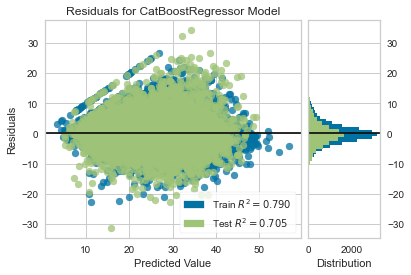

In [48]:
exp.plot_model(best, plot = 'residuals')

### feature importance

下圖展示了那些特徵對於預測的重要性。

可以看出，lagged feature 貢獻了許多的重要性。

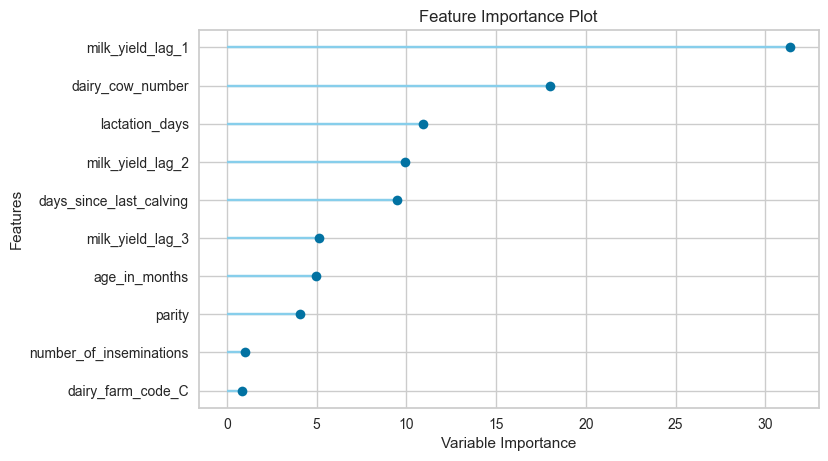

In [49]:
exp.plot_model(best, plot = 'feature')

### 預測結果

In [50]:
pred = exp.predict_model(best, data=dftest.drop(columns='milk_yield'))

### 將結果組成 AIDEA 的上傳格式

In [51]:
dfsub = pd.read_csv('data/submission.csv')
# for each record in pred, assign the prediction_label to dfsub with the same ID
for i, row in pred.iterrows():
    dfsub.loc[dfsub['ID'] == row['ID'], '1'] = row['prediction_label'] 
dfsub.head()

,ID,1
0,480,14.680695
1,742,30.029262
2,743,28.339295
3,744,27.049228
4,745,21.726874


In [52]:
dfsub.to_csv('data/submission_6.csv', index=False, encoding='utf-8')

## 實驗 2: 移除 lagged features

雖然在上面的實驗中我們看到 lagged feature 對於模型預測能力的影響。

但是我們的測試集中，其實存在有許多資料，是沒有 lagged feature 的。這代表測試集其實長像和 training set 不太一樣。

所以我們的模型依賴 lagged feature 來預測，有可能會造成在測試集上表現不好。

因此我們在第 2 個實驗中，把 lagged feature 拿掉，訓練模型只用剩下的特徵來做預測。

In [53]:
# 由底下的資料中可以看到，前 5 筆資料中，就有 4 筆的 lagged features 是 0。也就是它們是空值。
dftest.head()

,ID,data_year,data_month,dairy_farm_code,dairy_cow_number,parity,lactation_days,milk_yield,age_in_months,number_of_inseminations,health,weight,milk_yield_lag_1,milk_yield_lag_2,milk_yield_lag_3,season,days_since_last_calving
479,480,2019,1,A,52631,4,435.0,NaN,94,6,H,576.584507,15.8,20.6,25.3,winter,435
741,742,2019,2,A,52640,4,13.0,NaN,94,0,H,576.584507,0.0,0.0,0.0,winter,13
742,743,2019,3,A,52640,4,35.0,NaN,95,1,H,576.584507,0.0,0.0,0.0,spring,35
743,744,2019,4,A,52640,4,70.0,NaN,96,1,H,576.584507,0.0,0.0,0.0,spring,70
744,745,2019,5,A,52640,4,98.0,NaN,97,1,N,576.584507,0.0,0.0,0.0,spring,98


統計 test 資料集中，有多少筆資料是有 lagged feature，有多少筆沒有 lagged features

In [54]:
# count the number of records in the dftest that milk_yield_lag_1 != 0 and milk_yield_lag_1 == 0
print('milk_yield_lag_1 != 0:', dftest[dftest['milk_yield_lag_1'] != 0].shape[0])
print('milk_yield_lag_1 == 0:', dftest[dftest['milk_yield_lag_1'] == 0].shape[0])

milk_yield_lag_1 != 0: 541
milk_yield_lag_1 == 0: 3722


可以看到，有一大堆資料 (3722 筆) 是沒有 lagged feature 的。那麼我們訓練的模型如果很依賴 lagged feature 來做預測，那會有不好的表現是可以預期的。

In [55]:
exp_without_lag = RegressionExperiment()
# 跟模型說不要理 lagged features
ignore_features = ignore_features + ['milk_yield_lag_1', 'milk_yield_lag_2', 'milk_yield_lag_3']
# remove 'milk_yield_lag_1', 'milk_yield_lag_2', 'milk_yield_lag_3' from num_features
num_features = [col for col in num_features if col not in ['milk_yield_lag_1', 'milk_yield_lag_2', 'milk_yield_lag_3']]
exp_without_lag.setup(data=dftrain,
          target = 'milk_yield', 
          normalize=True,
          normalize_method='minmax',
          transformation=True,
          #transform_target=True,
          #transformation_method='quantile',
          #test_data=dftest,
          categorical_features=cat_features, # 指定類別變數欄位
          numeric_features=num_features, # 指定數值變數欄位
          ordinal_features=ordinal_features, # 指定有序變數欄位
          ignore_features=ignore_features, # 在進行預測時，忽略 ID 欄位
          remove_outliers=False, # 不要移除離群值，可以設為 True 來移除離群值
          #outliers_method='iforest', 使用 iforest 來偵測離群值, 還有 ee 以及 lof 可以選
          session_id = 123)

,Description,Value
0,Session id,123
1,Target,milk_yield
2,Target type,Regression
3,Original data shape,"(33253, 17)"
4,Transformed data shape,"(33253, 16)"
5,Transformed train set shape,"(23277, 16)"
6,Transformed test set shape,"(9976, 16)"
7,Ignore features,6
8,Ordinal features,1
9,Numeric features,5


In [56]:
best = exp_without_lag.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,4.1538,30.2798,5.5021,0.6037,0.2768,0.6083,1.3640
xgboost,Extreme Gradient Boosting,4.1649,30.6375,5.5343,0.5990,0.2773,0.6015,0.0940
rf,Random Forest Regressor,4.1957,31.1373,5.5791,0.5926,0.2778,0.6123,0.7030
lightgbm,Light Gradient Boosting Machine,4.2376,31.2860,5.5927,0.5905,0.2808,0.6176,0.1580
et,Extra Trees Regressor,4.3112,32.9325,5.7372,0.5691,0.2831,0.6099,0.5290
gbr,Gradient Boosting Regressor,4.3817,33.2953,5.7693,0.5643,0.2888,0.6328,0.2680
knn,K Neighbors Regressor,4.5399,35.8596,5.9876,0.5306,0.2946,0.6481,0.1240
ada,AdaBoost Regressor,5.0662,41.5328,6.4431,0.4566,0.3152,0.6826,0.1780
ridge,Ridge Regression,5.1007,44.0110,6.6333,0.4239,0.3236,0.7159,0.0720
br,Bayesian Ridge,5.1010,44.0169,6.6337,0.4239,0.3236,0.7157,0.0670


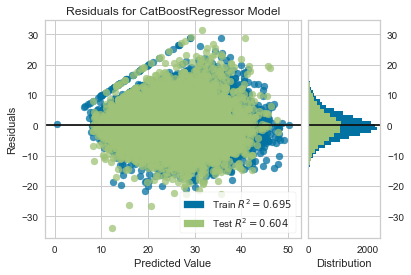

In [57]:
exp_without_lag.plot_model(best, plot = 'residuals')

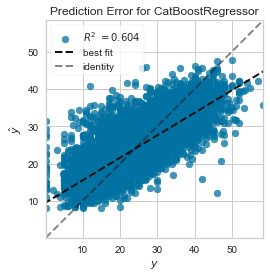

In [58]:
exp_without_lag.plot_model(best, plot = 'error')

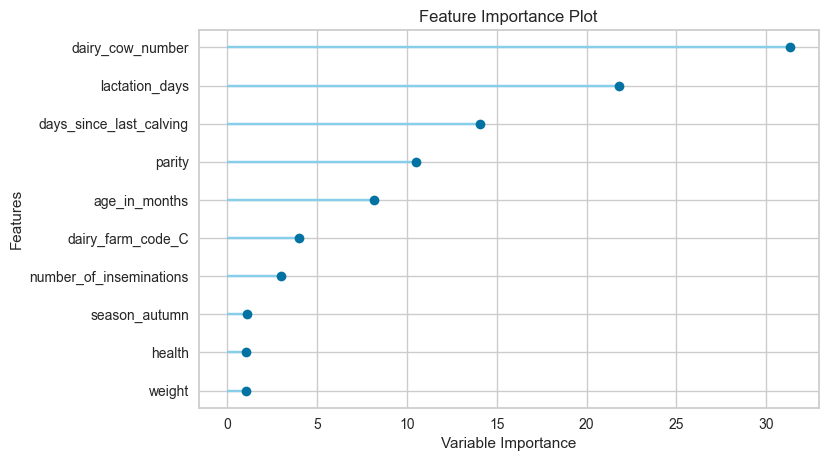

In [59]:
exp_without_lag.plot_model(best, plot = 'feature')

### 組成 AIDEA 的格式

In [60]:
pred = exp.predict_model(best, data=dftest.drop(columns='milk_yield'))
dfsub = pd.read_csv('data/submission.csv')
# for each record in pred, assign the prediction_label to dfsub with the same ID
for i, row in pred.iterrows():
    dfsub.loc[dfsub['ID'] == row['ID'], '1'] = row['prediction_label'] 
dfsub.to_csv('data/submission_no_lag_2.csv', index=False, encoding='utf-8')
dfsub.head()

,ID,1
0,480,16.828408
1,742,30.681687
2,743,31.508973
3,744,30.933224
4,745,22.757437


## 實驗 3

我們發現我們的 train 資料集和 test 資料集的長相有點不一樣，這會造成訓練時，評價訓練結果不太準確。

In [65]:
print(f'Number of records that have lagged features in train {dftrain.loc[dftrain.milk_yield_lag_1!=0].shape[0]}')
print(f'Number of records that have no lagged features in train {dftrain.loc[dftrain.milk_yield_lag_1==0].shape[0]}')
print(f'Number of records that have lagged features in test {dftest.loc[dftest.milk_yield_lag_1!=0].shape[0]}')
print(f'Number of records that have no lagged features in test {dftest.loc[dftest.milk_yield_lag_1==0].shape[0]}')

Number of records that have lagged features in train 29697
Number of records that have no lagged features in train 3556
Number of records that have lagged features in test 541
Number of records that have no lagged features in test 3722


在訓練集中，有許多的資料都有 lagged feature，但在測試集中，卻沒有。

這就是為什麼實驗 2 中的模型，在 AIDEA 中會表現比較好的原因。

In [71]:
cow_id_test = dftest.dairy_cow_number.unique()
cow_id_train = dftrain.dairy_cow_number.unique()
total_test_cows = len(cow_id_test)
total_test_train_cows = len(np.intersect1d(cow_id_train, cow_id_test))
only_test_cows = len(np.setdiff1d(cow_id_test, cow_id_train))
print(f'Number of cows both in train and test: {total_test_train_cows} ({total_test_train_cows/total_test_cows:.2f})')
print(f'Number of cows only in test: {only_test_cows} ({only_test_cows/total_test_cows:.2f})')

Number of cows both in train and test: 676 (0.80)
Number of cows only in test: 170 (0.20)


由前述的分析可以看出，在 test set 中，出現有部分的牛隻，它們的 id 是在 training set 中沒有的。

但大部分的牛隻 (80%)，其 id 都在 training set 中出現。這就是為什麼我們把牛隻的 id 放入資料集中後，會有效能的提升。

In [95]:
train_copy = dftrain.copy()
train_copy.drop(columns=['milk_yield_lag_1', 'milk_yield_lag_2', 'milk_yield_lag_3'], inplace=True)
# fill milk_yield with nan if data_year is 2018
train_copy.loc[train_copy.data_year == 2018, 'milk_yield'] = np.nan
train_copy_with_lags = create_lagged_features(train_copy, ['milk_yield'], group_cols=['dairy_cow_number', 'parity'])

In [96]:
# Assuming that 'key' is the common column in both dataframes
for index, row in train_copy_with_lags.iterrows():
    if row['data_year'] != 2018:
        continue
    corresponding_row = dftrain.loc[dftrain['ID'] == row['ID']]
    if not corresponding_row.empty:
        # get the first value of 'data_year' column
        assert corresponding_row.data_year.values[0] == 2018
        assert corresponding_row.dairy_cow_number.values[0] == row.dairy_cow_number
        train_copy_with_lags.at[index, 'milk_yield'] = corresponding_row['milk_yield'].values[0]

In [97]:
train_copy_with_lags.milk_yield_lag_1.fillna(0, inplace=True)
train_copy_with_lags.milk_yield_lag_2.fillna(0, inplace=True)
train_copy_with_lags.milk_yield_lag_3.fillna(0, inplace=True)

In [98]:
dftrain_new = train_copy_with_lags.loc[train_copy_with_lags['data_year'] != 2018]
dfval_new = train_copy_with_lags.loc[train_copy_with_lags['data_year'] == 2018]

In [100]:
print(f'Number of records that have lagged features in train {dftrain_new.loc[dftrain_new.milk_yield_lag_1!=0].shape[0]}')
print(f'Number of records that have no lagged features in train {dftrain_new.loc[dftrain_new.milk_yield_lag_1==0].shape[0]}')
print(f'Number of records that have lagged features in val {dfval_new.loc[dfval_new.milk_yield_lag_1!=0].shape[0]}')
print(f'Number of records that have no lagged features in val {dfval_new.loc[dfval_new.milk_yield_lag_1==0].shape[0]}')

Number of records that have lagged features in train 23269
Number of records that have no lagged features in train 2825
Number of records that have lagged features in val 466
Number of records that have no lagged features in val 6693


我們造出的 dfval_new 也是無 lagged feature 數量較多，而有 lagged feature 的數量較少。

In [101]:
cow_id_val = dfval_new.dairy_cow_number.unique()
cow_id_train = dftrain_new.dairy_cow_number.unique()
total_val_cows = len(cow_id_val)
total_val_train_cows = len(np.intersect1d(cow_id_train, cow_id_val))
only_val_cows = len(np.setdiff1d(cow_id_val, cow_id_train))
print(f'Number of cows both in train and test: {total_val_train_cows} ({total_val_train_cows/total_val_cows:.2f})')
print(f'Number of cows only in test: {only_val_cows} ({only_val_cows/total_val_cows:.2f})')

Number of cows both in train and test: 595 (0.66)
Number of cows only in test: 303 (0.34)


In [103]:
# 類別變數欄位
cat_features = ['dairy_farm_code', 'dairy_cow_number', 'health', 'season']
ordinal_features = {'parity':[1,2,3,4,5,6,7,8,9,11]}
# 數值變數欄位
num_features = ['lactation_days', 'age_in_months', 'weight', 'number_of_inseminations', 'milk_yield_lag_1', 'milk_yield_lag_2', 'milk_yield_lag_3', 'days_since_last_calving']
ignore_features = ['ID', 'data_year', 'data_month']
#print(len(cat_features) + len(num_features) + len(ignore_features) + len(ordinal_features))
#print(len(dftrain.columns))
# +1 是要加上 target 欄位 'milk_yield'
assert len(cat_features) + len(num_features) + len(ignore_features) + len(ordinal_features) + 1 == len(dftrain.columns)

In [104]:
exp.setup(data=dftrain_new, 
          target = 'milk_yield', 
          normalize=True,
          normalize_method='minmax', # 使用 min-max normalization，也可以使用 z-score normalization
          transformation=True, # 使用 yeo-johnson transformation 數值資料轉成常態分佈，也可以使用 quantile transformation
          #transform_target=True,
          #transformation_method='quantile', # 如果要使用 quantile transformation，這裡要設定 'quantile'，不然預設是 yeo-johnson
          test_data=dfval_new,
          categorical_features=cat_features, # 指定類別變數欄位
          numeric_features=num_features, # 指定數值變數欄位
          ordinal_features=ordinal_features, # 指定有序變數欄位
          ignore_features=ignore_features, # 在進行預測時，忽略 ID 欄位
          remove_outliers=False, # 不要移除離群值，可以設為 True 來移除離群值
          #outliers_method='iforest', 使用 iforest 來偵測離群值, 還有 ee 以及 lof 可以選
          session_id = 123)

,Description,Value
0,Session id,123
1,Target,milk_yield
2,Target type,Regression
3,Original data shape,"(33253, 17)"
4,Transformed data shape,"(33253, 19)"
5,Transformed train set shape,"(26094, 19)"
6,Transformed test set shape,"(7159, 19)"
7,Ignore features,3
8,Ordinal features,1
9,Numeric features,8


In [105]:
best = exp.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,3.8677,27.6325,5.2356,0.6349,0.2614,0.6293,1.6470
gbr,Gradient Boosting Regressor,3.8707,27.6496,5.2392,0.6344,0.2650,0.6440,0.3920
lightgbm,Light Gradient Boosting Machine,3.8693,27.6330,5.2425,0.6331,0.2632,0.6316,0.1670
et,Extra Trees Regressor,3.8522,27.9560,5.2646,0.6306,0.2628,0.6369,0.7540
rf,Random Forest Regressor,4.0129,29.9231,5.4576,0.6023,0.2692,0.6453,1.1670
xgboost,Extreme Gradient Boosting,4.0293,30.1671,5.4680,0.6022,0.2692,0.6372,0.1350
knn,K Neighbors Regressor,4.1739,31.6294,5.5985,0.5826,0.2770,0.6547,0.1300
huber,Huber Regressor,4.6052,37.9075,6.1330,0.4990,0.3011,0.6872,0.2290
lr,Linear Regression,4.7879,39.0207,6.2261,0.4828,0.3057,0.7070,1.3450
ridge,Ridge Regression,4.7925,39.0720,6.2302,0.4821,0.3058,0.7077,0.0880


In [106]:
exp.pull()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,3.8677,27.6325,5.2356,0.6349,0.2614,0.6293,1.647
gbr,Gradient Boosting Regressor,3.8707,27.6496,5.2392,0.6344,0.2650,0.6440,0.392
lightgbm,Light Gradient Boosting Machine,3.8693,27.6330,5.2425,0.6331,0.2632,0.6316,0.167
et,Extra Trees Regressor,3.8522,27.9560,5.2646,0.6306,0.2628,0.6369,0.754
rf,Random Forest Regressor,4.0129,29.9231,5.4576,0.6023,0.2692,0.6453,1.167
xgboost,Extreme Gradient Boosting,4.0293,30.1671,5.4680,0.6022,0.2692,0.6372,0.135
knn,K Neighbors Regressor,4.1739,31.6294,5.5985,0.5826,0.2770,0.6547,0.130
huber,Huber Regressor,4.6052,37.9075,6.1330,0.4990,0.3011,0.6872,0.229
lr,Linear Regression,4.7879,39.0207,6.2261,0.4828,0.3057,0.7070,1.345
ridge,Ridge Regression,4.7925,39.0720,6.2302,0.4821,0.3058,0.7077,0.088


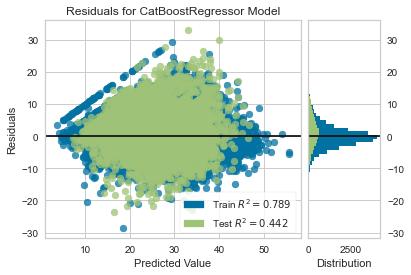

In [107]:
exp.plot_model(best, plot = 'residuals')

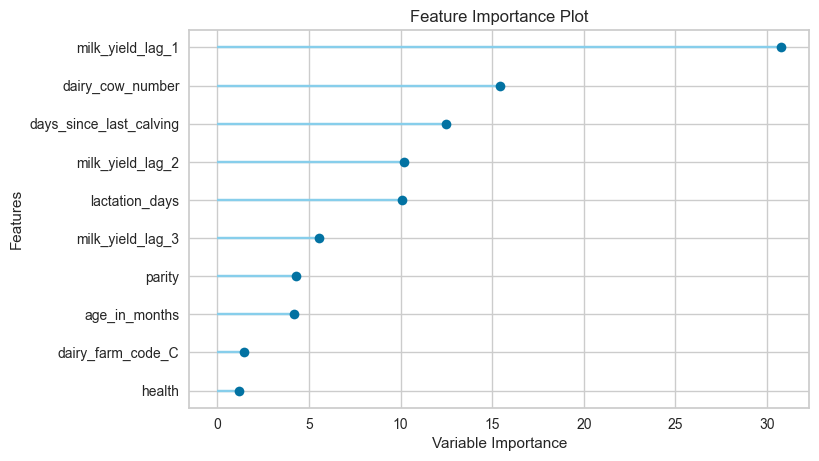

In [109]:
exp.plot_model(best, plot = 'feature')